In [104]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
#import os 
from scipy.stats import norm
import scipy.stats as sps
import cv2
from scipy.ndimage import convolve
import skimage
from scipy import ndimage
from scipy.spatial.distance import cdist
from nibabel.testing import data_path
import nibabel as nib
from sklearn.mixture import GaussianMixture
import pandas as pd
import skimage.measure
import seaborn as sns
import scipy as sp
import gudhi as gd
import random
import glob
from function_geometry import * 
from codegeometry import * 
from PIL import Image

In [2]:
from gtda.plotting import plot_point_cloud
import matplotlib.pyplot as plt
from gtda.diagrams import PersistenceLandscape, Silhouette, PersistenceEntropy, NumberOfPoints, Amplitude
from sklearn.preprocessing import StandardScaler

In [4]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(train_dir, test_dir):
    # train and valid dataframe
    files, classes = define_paths(train_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
    # test dataframe
    files, classes = define_paths(test_dir)
    test_df = define_df(files, classes)
    
    return train_df, valid_df, test_df

In [134]:
def preprocessing_data_3c(l):
    U = []
    for M in l:
        Z = np.zeros(M.shape)
        Z[:,:,0] = (-1)*M[:,:,0] - np.min((-1)*M[:,:,0])
        Z[:,:,0] = (Z[:,:,0] - np.mean(Z[:,:,0]))/np.std(Z[:,:,0])
        Z[:,:,1] = (-1)*M[:,:,1] - np.min((-1)*M[:,:,1])
        Z[:,:,1] = (Z[:,:,0] - np.mean(Z[:,:,1]))/np.std(Z[:,:,1])
        Z[:,:,2] = (-1)*M[:,:,2] - np.min((-1)*M[:,:,2])
        Z[:,:,2] = (Z[:,:,2] - np.mean(Z[:,:,2]))/np.std(Z[:,:,2])
        U.append(Z) #pour avoir les bonnes valeurs en haut

In [3]:
def preprocessing_data(path, T):
    U = []
    w = 0 
    for i in os.listdir(path):
        if w < T: 
            img = os.path.join(path, i)
            M = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
            Z = (-1)*M - np.min((-1)*M)
            Z = (Z - np.mean(Z))/np.std(Z)
            U.append(Z) #pour avoir les bonnes valeurs en haut 
            w = w+1
    return U

def preprocessing_data_rgb(path, T):
    U = []
    w = 0 
    for i in os.listdir(path):
        if w < T: 
            img = os.path.join(path, i)
            M = cv2.imread(img, cv2.IMREAD_UNCHANGED)
            Z = np.zeros(M.shape)
            Z[:,:,0] = (-1)*M[:,:,0] - np.min((-1)*M[:,:,0])
            Z[:,:,0] = (Z[:,:,0] - np.mean(Z[:,:,0]))/np.std(Z[:,:,0])
            Z[:,:,1] = (-1)*M[:,:,1] - np.min((-1)*M[:,:,1])
            Z[:,:,1] = (Z[:,:,0] - np.mean(Z[:,:,1]))/np.std(Z[:,:,1])
            Z[:,:,2] = (-1)*M[:,:,2] - np.min((-1)*M[:,:,2])
            Z[:,:,2] = (Z[:,:,2] - np.mean(Z[:,:,2]))/np.std(Z[:,:,2])
            U.append(Z) #pour avoir les bonnes valeurs en haut
            w=w+1
    return U

def Perimetre_Hermine(X, t):
    [M,N] = np.shape(X)
    L_1 = np.sum((X[0:M-1,0:N]>t)*(X[1:M,0:N]<=t))
    L_2 = np.sum((X[0:M,0:N-1]>t)*(X[0:M,1:N]<=t))
    L_3 = np.sum((X[0:M-1,0:N]<=t)*(X[1:M,0:N]>t))
    L_4 = np.sum((X[0:M,0:N-1]<=t)*(X[0:M,1:N]>t))
    L = L_1 + L_2 + L_3 + L_4
    return L

def Area(X, t):
    if isinstance(X, np.ndarray):
        return np.sum(X>=t)
    else:
        return None

def Euler(image_binary):
    if np.max(image_binary) > 1:
        raise ValueError("Input image must be binary")
    
    # Add a border of zeros around the image
    u = np.pad(image_binary, [(1, 1), (1, 1)], mode='constant')
    
    # Compute the matrix S of Ebner
    mtri = u[:-2, :-2] + u[:-2, 1:-1] + u[1:-1, :-2] + u[2:, 1:-1] + u[1:-1, 2:] + u[2:, 2:]
    
    # Count the number of crossings
    S_0 = np.count_nonzero((u[1:-1, 1:-1] == 0) & (u[2:, 2:] == 0))
    S_1 = np.count_nonzero((u[1:-1, 1:-1] == 1) & (u[2:, 2:] == 1))
    
    # Compute the Euler characteristic
    E = (1/4)*np.sum(mtri == 1) - (1/4)*np.sum(mtri == 3) - (0.5*S_0 + 0.5*S_1)
    return E

In [7]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [8]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [9]:
train_dir = './data/train'
test_dir = './data/test'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(train_dir, test_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


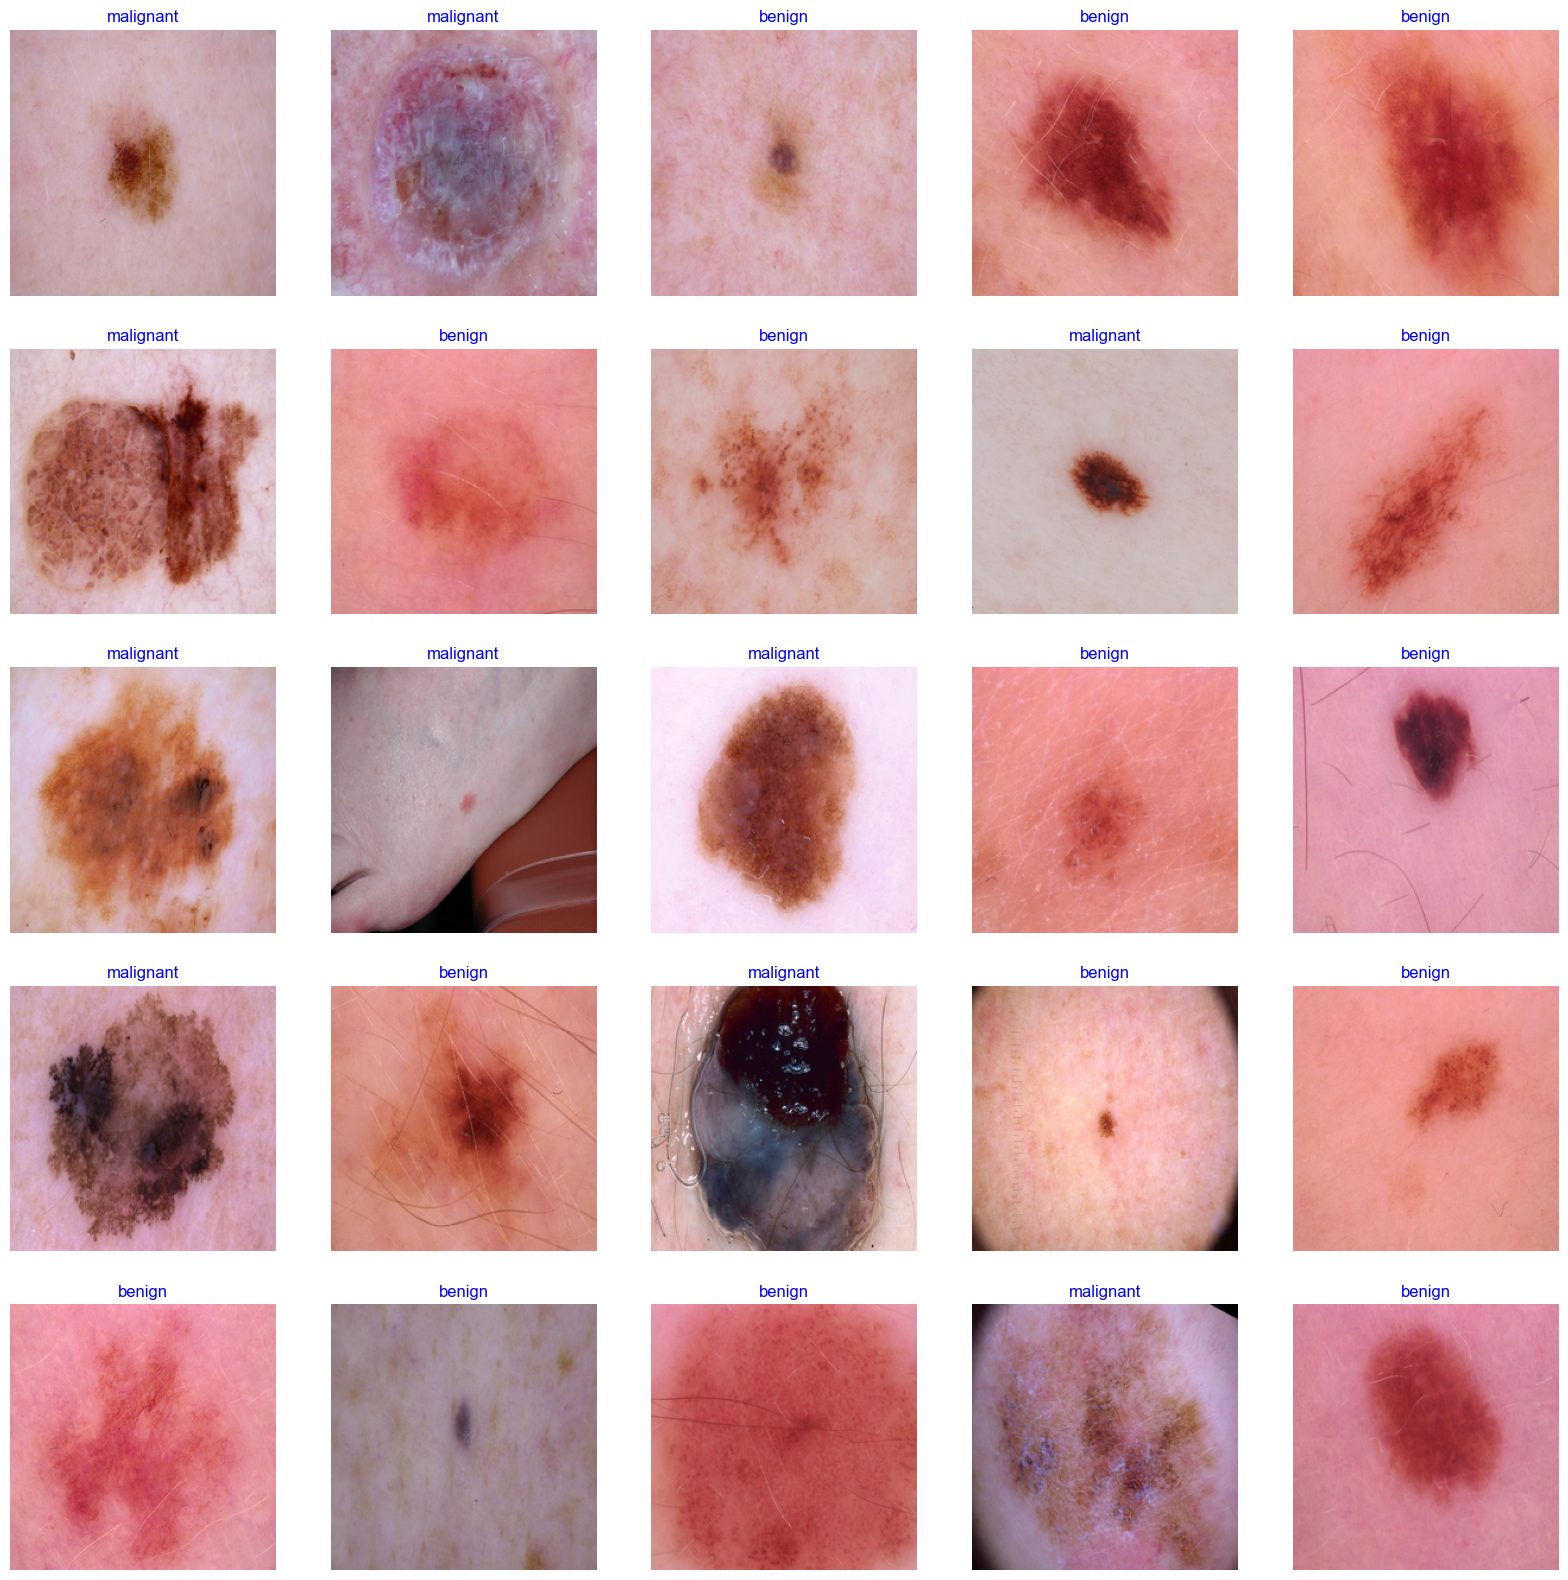

In [10]:
show_images(train_gen)

In [16]:
len(train_df), len(valid_df), len(test_df)

(2109, 528, 660)

In [4]:
path_train_b = "./data/train/benign/"
path_train_m = "./data/train/malignant/"
path_test_b = "./data/test/benign/"
path_test_m = "./data/test/malignant/"

In [94]:
size = 2000

U_train_b = preprocessing_data(path_train_b, size)
U_train_m = preprocessing_data(path_train_m, size)
U_test_b = preprocessing_data(path_test_b, size)
U_test_m = preprocessing_data(path_test_m, size)



In [95]:
U_train = np.concatenate([U_train_b, U_train_m], axis=0)
U_test = np.concatenate([U_test_b, U_test_m], axis=0)

In [96]:
labels = [0]*len(U_train_b) + [1]*len(U_train_m) + [0]*len(U_test_b) + [1]*len(U_test_m)

In [97]:
from gtda.diagrams import HeatKernel
from gtda.images import Binarizer
from gtda.images import RadialFiltration
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler
import scipy.stats as st

In [98]:
#So now that we know how to generate new topological features, let’s combine them using scikit-learn’s utility function for feature unions:

from sklearn.pipeline import make_pipeline, make_union
from gtda.images import HeightFiltration
from gtda.images import RadialFiltration

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Select a variety of metrics to calculate amplitudes
metric_list = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape","betti", "heat", "silhouette","persistence_image"]
]

#metric_list_geo = [
 #   {"metric_geo": metric_geo}
  #  for metric_geo in ["U", "L"]
#]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
   # + [resume_geometrique(U,L) for metric_geo in metric_list_geo]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [174]:
type(train_gen)

keras.preprocessing.image.DataFrameIterator

In [179]:
X_train_tda.shape

(5, 40, 272)

In [140]:
#U_train = np.asarray(U_train_b + U_train_m)
batch_size =  5
X_train_tda = np.zeros((batch_size, train_gen[0][:][0][:, :,:,0].shape[0], 272))
#m = len(train_gen[0][])
for i in range(5):
    print(i)
    X_train_tda[i] = tda_union.fit_transform(train_gen[i][:][0][:, :,:,0])
    

0
1
2
3
4


In [ ]:
train_tda = (X_train_tda, )

In [142]:
#U_train = np.asarray(U_train_b + U_train_m)
#X_test_tda = np.zeros((len(train_gen), 40, 272))
#for i in range(len(test_df)):
#    print(i)
X_validation_tda = np.zeros((batch_size, valid_gen[0][:][0][:, :,:,0].shape[0], 272))
#m = len(train_gen[0][])
for i in range(5):
    print(i)
    X_validation_tda[i] = tda_union.fit_transform(valid_gen[i][:][0][:, :,:,0])
        

0
1
2
3
4


In [145]:

X_test_tda = np.zeros((batch_size, test_gen[0][:][0][:, :,:,0].shape[0], 272))
#m = len(train_gen[0][])
for i in range(5):
    print(i)
    X_test_tda[i] = tda_union.fit_transform(test_gen[i][:][0][:, :,:,0])
        

0
1
2
3
4


In [ ]:
#U_train = np.asarray(U_train_b + U_train_m)
#X_test_tda = np.zeros((len(train_gen), 40, 272))
#for i in range(len(test_df)):
#    print(i)
X_validation_tda = np.zeros((5, 40, 272))
#m = len(train_gen[0][])
for i in range(5):
    print(i)
    X_validation_tda[i] = tda_union.fit_transform(valid_gen[i][:][0][:, :,:,0])
        

In [99]:
X_train_tda = tda_union.fit_transform(U_train)
X_test_tda = tda_union.fit_transform(U_test)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit your curve (e.g., a polynomial function)
def func(x, a, b, c):
    return a * x**2 + b * x + c

# Generate some sample data for demonstration
x_data = np.linspace(-10, 10, 100)
y_data = func(x_data, 2, 3, 1)  # True curve parameters: a=2, b=3, c=1

# Add noise to the data
y_data_noisy = y_data + np.random.normal(scale=1, size=len(x_data))

# Fit the curve to the data
popt, pcov = curve_fit(func, x_data, y_data_noisy)

# Extract the fitted curve parameters
a_fit, b_fit, c_fit = popt

# Generate the fitted curve using the estimated parameters
y_fit = func(x_data, a_fit, b_fit, c_fit)

# Plot the original data, noisy data, and fitted curve
plt.plot(x_data, y_data, label='True Curve')
plt.scatter(x_data, y_data_noisy, label='Noisy Data')
plt.plot(x_data, y_fit, label='Fitted Curve')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting a Curve to Data')
plt.show()

In [100]:
import joblib
from tqdm import tqdm
import time

# Define n and the shape of XX_train_geo
Ncut = 200
M,N =X_train_tda.shape
N = 0
XX_train_geo = np.zeros((len(U_train), N + 3 * Ncut))


def process_U(i, U, Ncut):
    L = np.linspace(np.min(U), np.max(U), Ncut)
    #M,N =X_train_tda.shape
    N = 0
    row = np.zeros((N + 3 * Ncut,))
    #row[:N] = X_train_tda[i]
    area = np.zeros(Ncut)
    perimetre = np.zeros(Ncut)
    euler = np.zeros(Ncut)
    for k in range(Ncut): 
        area[k] = np.sum(U >= L[k]) 
        perimetre[k]  = Perimetre_Hermine(U, L[k]) 
        euler[ k ]=  Euler(U >= L[k]) 
        
    row[N:N+Ncut] = area
    row[N+Ncut:N+2*Ncut]  = perimetre
    row[N+2*Ncut:]=  euler
    #k = 0
    #for idx in life.keys(): 
    #    diagram_pondere[0, k, 0] = alpha.pdf(np.linalg.norm(per[idx]), 1.72)*life[idx][1]
    #    diagram_pondere[0, k, 1] = alpha.pdf(np.linalg.norm(per[idx]), 1.72)*life[idx][0]
    #    diagram_pondere[0, k, 2] = 0
    #    k += 1   
    #persistence_entropy = PersistenceEntropy(normalize=True)
    #diagram_pondere = np.array([i for i in diagram_pondere if np.isnan(i).any() == False])
    #row[-1] = persistence_entropy.fit_transform(diagram_pondere)
    return row

# Initialize the progress bar
pbar = tqdm(total=len(U_train))

# Loop over U_train
results = joblib.Parallel(n_jobs=-1)(joblib.delayed(process_U)(i, U, Ncut) for i, U in enumerate(U_train))

# Update the XX_train_geo array with the results
for i, row in enumerate(results):
    XX_train_geo[i] = row
    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()


  0%|                                                  | 0/2637 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [13]:
# Define n and the shape of XX_test_geo
N = X_test_tda.shape[1]
N =0
XX_test_geo = np.zeros((len(U_test), N + 3 * Ncut))


#def process_U(i, U):
 #   L = np.linspace(np.min(U), np.max(U), n)[::-1]
 #   life, barecode, persistence, connected_comp, Per_total, Area_total, euler_total, per, area, euler = function_persistance(U, L, False)
  #  row = np.zeros((N + 3 * n + 1,))
   # row[:N] = X_train_tda[i]
    #row[N:N+n] = Area_total
   # row[N+n:N+2*n] = Per_total - (4/224)*Area_total
   # row[N+2*n:-1] = euler_total - (4/(2*np.pi*224))*Per_total + ((1/(2*np.pi))*(4/224)**2 - 1/224)*Area_total
   # diagram_pondere = np.zeros((1, len(life), 3))
    
   # k = 0
   # for idx in life.keys():
   #     diagram_pondere[0, k, 0] = np.linalg.norm(per[idx])*life[idx][1]
   #     diagram_pondere[0, k, 1] = np.linalg.norm(per[idx])*life[idx][0]
   #     diagram_pondere[0, k, 2] = 0
   #     k += 1
   # persistence_entropy = PersistenceEntropy(normalize=True)
   # diagram_pondere = np.array([i for i in diagram_pondere if np.isnan(i).any() == False])
   # row[-1] = persistence_entropy.fit_transform(diagram_pondere)
   # return row

# Initialize the progress bar
pbar = tqdm(total=len(U_test))

# Loop over U_train
results = joblib.Parallel(n_jobs=-1)(joblib.delayed(process_U)(i, U, Ncut) for i, U in enumerate(U_test))

# Update the XX_train_geo array with the results
for i, row in enumerate(results):
    XX_test_geo[i] = row
    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

100%|█████████████████████████████████████████| 660/660 [00:11<00:00, 58.70it/s]


In [14]:
T = len(U_train)
y_train = labels[:T]
y_test = labels[T:]

In [15]:
XX_test_geo.shape, XX_train_geo.shape, len(y_test), len(U_test)

((660, 600), (2637, 600), 660, 660)

# Geometry

In [93]:
from sklearn.ensemble import RandomForestClassifier
XX_train_geo = StandardScaler().fit_transform(XX_train_geo)
rf = RandomForestClassifier()
# Set the parameters
rf.set_params(
    n_estimators= 90, # Number of trees in the forest
    criterion='gini', # Impurity measure for splitting
    max_depth=None, # Maximum depth of each tree (None means unlimited)
    min_samples_split=2, # Minimum number of samples required to split an internal node
    min_samples_leaf=1, # Minimum number of samples required to be at a leaf node
    max_features='sqrt', # Maximum number of features to consider when splitting
    bootstrap=True, # Whether to use bootstrap samples when building trees
    random_state=123, # Seed for the random number generator
    n_jobs=-1 # Number of CPU cores to use for parallelization (-1 means use all available cores)
)
rf.fit(XX_train_geo, y_train)
XX_test_geo = StandardScaler().fit_transform(XX_test_geo)
#X_test_tda = tda_union.transform(U_test)
rf.score(XX_test_geo, y_test)

0.7636363636363637

In [55]:
import itertools

In [76]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [60]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
 '''
 This function plot confusion matrix method from sklearn package. 
 '''
 plt.figure(figsize= (10, 10))
 plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
 plt.title(title)
 plt.colorbar()

 tick_marks = np.arange(len(classes))
 plt.xticks(tick_marks, classes, rotation= 45)
 plt.yticks(tick_marks, classes)

 if normalize:
    cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
    print('Normalized Confusion Matrix')
 else:
    print('Confusion Matrix, Without Normalization')
 print(cm)

 thresh = cm.max() / 2.
 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[295  65]
 [ 91 209]]
              precision    recall  f1-score   support

      benign       0.76      0.82      0.79       360
      malign       0.76      0.70      0.73       300

    accuracy                           0.76       660
   macro avg       0.76      0.76      0.76       660
weighted avg       0.76      0.76      0.76       660



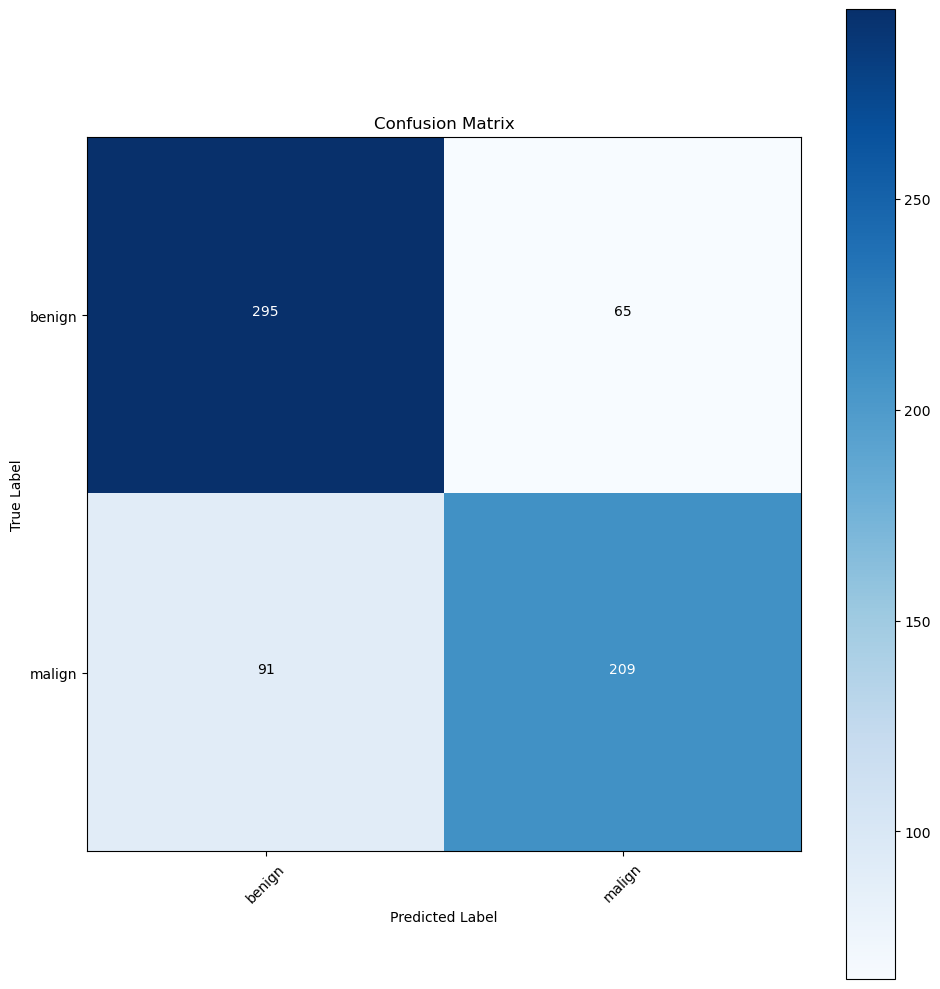

In [62]:
classes = ['benign','malign']
from sklearn.metrics import confusion_matrix, classification_report
# Confusion matrix
cm = confusion_matrix(y_test, rf.predict(XX_test_geo))
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(y_test, rf.predict(XX_test_geo), target_names= classes))

In [ ]:
help()

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np

XX_train_geo = np.asarray(XX_train_geo)

# Define the input shape of the patient data
data_shape = XX_train_geo.shape[1:]

# Define the generator model
def build_generator():

    model = Sequential()

    model.add(Dense(128, input_dim=data_shape[0]))
    model.add(LeakyReLU(alpha=1e-2))
    model.add(BatchNormalization(momentum=0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=1e-2))
    model.add(BatchNormalization(momentum=0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=1e-2))
    model.add(BatchNormalization(momentum=0.3))
    model.add(Dense(np.prod(data_shape), activation='tanh'))
    model.add(Reshape(data_shape))

    return model

# Define the discriminator model
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=data_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=1e-2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=1e-2))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Build the generator and discriminator models
generator = build_generator()
discriminator = build_discriminator()

# Define the optimizer for both generator and discriminator
optimizer = Adam(0.0002, 0.5)

# Compile the discriminator model
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# The generator takes noise as input and generates data
z = Input(shape=(423,))
data = generator(z)

# For the combined model, only train the generator
discriminator.trainable = False

# The discriminator takes generated data as input and determines validity
validity = discriminator(data)

# The combined model (generator and discriminator)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

epochs = 100
batch_size = 64

# The save_generated_samples parameter specifies how often (in epochs) to save generated samples during training. For example, if save_generated_samples=10, generated samples will be saved every 10 epochs.
# You can change this parameter according to your preference. It's a good idea to save generated samples periodically during training so you can monitor the progress of the model and ensure it's learning properly.

def save_generated_samples(epoch, generator, r=2, c=5, img_shape=None):
    # Generate images from the generator
    noise = np.random.normal(0, 1, (r*c, 423))
    gen_imgs = generator.predict(noise)

    # Reshape each generated image to the specified shape
    gen_imgs = gen_imgs.reshape((-1, 2, 5, 423))

    # Create a figure to display the images
    fig, axs = plt.subplots(r, c)
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

    # Save the figure
    fig.savefig("generated_samples_%d.png" % epoch)
    plt.close()


# Train the generator and discriminator alternately
for epoch in range(epochs):

    # Train the discriminator
    idx = np.random.randint(0, XX_train_geo.shape[0], batch_size)
    real_data = XX_train_geo[idx]
    noise = np.random.normal(0, 1, (batch_size, 423))
    generated_data = generator.predict(noise)

    # Train the discriminator on real data
    discriminator_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))

    # Train the discriminator on generated data
    discriminator_loss_generated = discriminator.train_on_batch(generated_data, np.zeros((batch_size, 1)))

    # Compute the total discriminator loss
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_generated)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, 423))

    # The generator wants the discriminator to label the generated data as valid
    generator_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print the progress
    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], generator_loss))

    sample_interval = 10 # tune between the range [100,1000] 
        
    # If at save interval, save generated data samples
    if epoch % sample_interval == 0:
        save_generated_samples(epoch, generator)
        
# save the GAN model
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")       


In [54]:
combined.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 423)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 423)               439463    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 348673    
                                                                 
Total params: 788,136
Trainable params: 437,671
Non-trainable params: 350,465
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import load_model

#generator = load_model("generator_model.h5")
#discriminator = load_model("discriminator_model.h5")

In [71]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.stats import entropy

# Load pre-trained Inception-v3 model
model = combined#InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Define function to compute Inception Score
def compute_inception_score(images, n_split=10):
    # Preprocess images for Inception-v3
    images = XX_train_geo#preprocessing_data(images, 50)

    # Compute predictions for all images
    preds = model.predict(images)

    # Split predictions into n_split chunks
    preds_split = np.array_split(preds, n_split)

    # Compute class distribution for each chunk
    preds_dist = [np.exp(preds) / np.sum(np.exp(preds), axis=1, keepdims=True) for preds in preds_split]

    # Compute marginal class distribution across all chunks
    p_y = np.mean(preds_dist, axis=0)

    # Compute KL divergence for each chunk and average across chunks
    scores = []
    for preds in preds_dist:
        scores.append(entropy(preds.T, p_y.T))
    return np.exp(np.mean(scores))

# Generate some images with the generator
num_images = 1000
noise = np.random.normal(0, 1, (num_images, 423))
generated_images = generator.predict(noise)

# Compute Inception Score for generated images
inception_score = compute_inception_score(generated_images)
print("Inception Score:", inception_score)



4/4 [==============================] - 0s 2ms/step
Inception Score: 1.0


# MLP

In [507]:
from sklearn.neural_network import MLPClassifier
XX_train_geo = StandardScaler().fit_transform(XX_train_geo)
mlp = MLPClassifier(alpha=1e-1, max_iter=2000, solver='lbfgs', hidden_layer_sizes=(50, 2), random_state=0)
mlp.fit(XX_train_geo, y_train)
XX_test_geo = StandardScaler().fit_transform(XX_test_geo)
#X_test_tda = tda_union.transform(U_test)
mlp.score(XX_test_geo, y_test)

0.7181818181818181

# SVM

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix 

classifier_geo = SVC(kernel='rbf', random_state=0)
classifier_geo.fit (XX_train_geo, y_train)
y_pred_geo = classifier_geo.predict(XX_test_geo)
cm = confusion_matrix(y_test, y_pred_geo)
accuracy = float(cm.diagonal().sum())/len(y_test)
print("\nAccuracy of SVM for the given dataset : ", accuracy)


Accuracy of SVM for the given dataset :  0.7378787878787879


# TDA only!

In [25]:
from sklearn.ensemble import RandomForestClassifier
X_train_tda = StandardScaler().fit_transform(X_train_tda)
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)
X_test_tda = StandardScaler().fit_transform(X_test_tda)
#X_test_tda = tda_union.transform(U_test)
rf.score(X_test_tda, y_test)

0.593939393939394

In [28]:
from sklearn.neural_network import MLPClassifier
X_train_tda = StandardScaler().fit_transform(X_train_tda)
mlp = MLPClassifier(alpha=1e-1, max_iter=2000, solver='lbfgs', hidden_layer_sizes=(50, 2), random_state=123)
mlp.fit(X_train_tda, y_train)
X_test_tda = StandardScaler().fit_transform(X_test_tda)
#X_test_tda = tda_union.transform(U_test)
mlp.score(X_test_tda, y_test)

/Users/morilla/anaconda3/envs/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.5712121212121212

In [102]:
classifier_tda = SVC(kernel='rbf', random_state=0)
classifier_tda.fit (X_train_tda, y_train)
y_pred_tda = classifier_tda.predict(X_test_tda)
cm = confusion_matrix(y_test, y_pred_tda)
accuracy = float(cm.diagonal().sum())/len(y_test)
print("\nAccuracy of SVM for the given dataset : ", accuracy)


Accuracy of SVM for the given dataset :  0.5878787878787879


# Manually testing

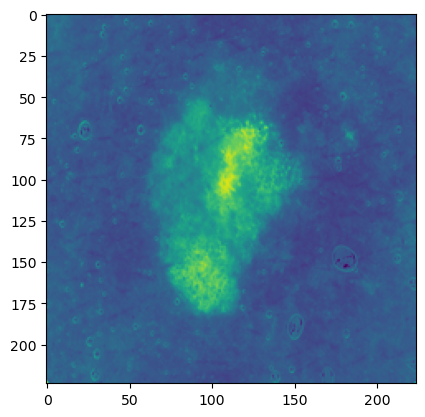

In [53]:
m = 99
U = U_train[m]
plt.imshow(U)

wp 2 level 228.66666666666669
connected_components 1


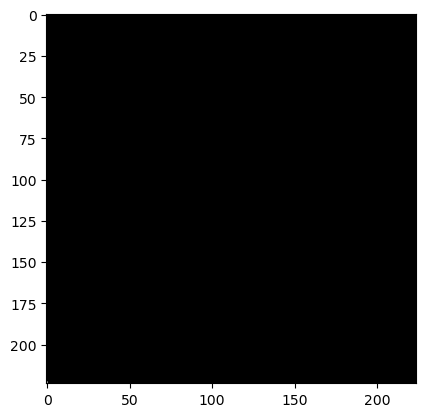

wp 3 level 226.33333333333334
connected_components 1


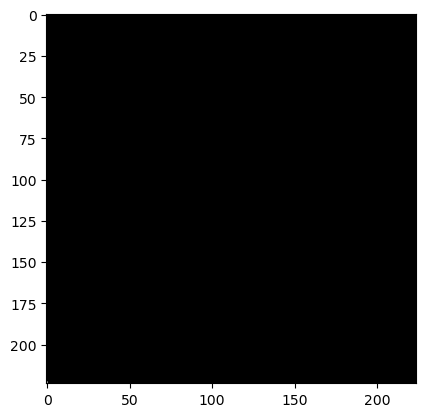

wp 4 level 224.0
connected_components 1


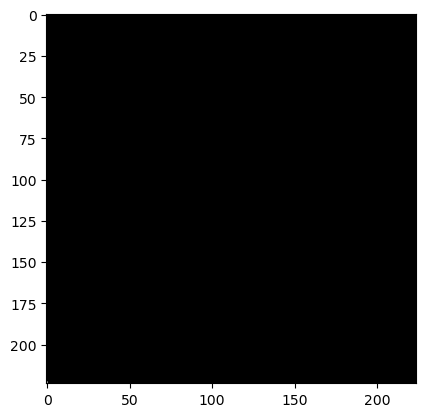

wp 5 level 221.66666666666669
connected_components 1


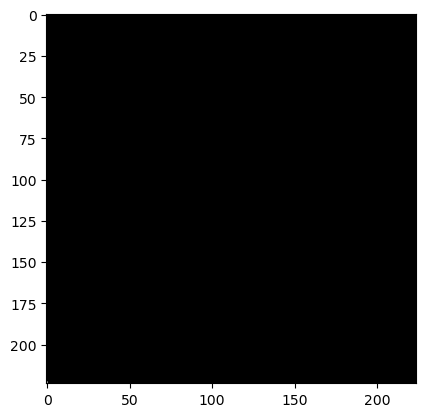

wp 6 level 219.33333333333334
connected_components 2


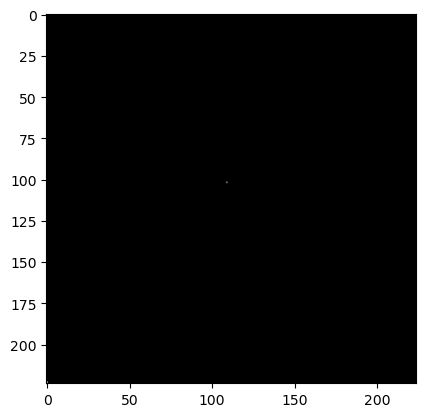

wp 7 level 217.0
connected_components 2


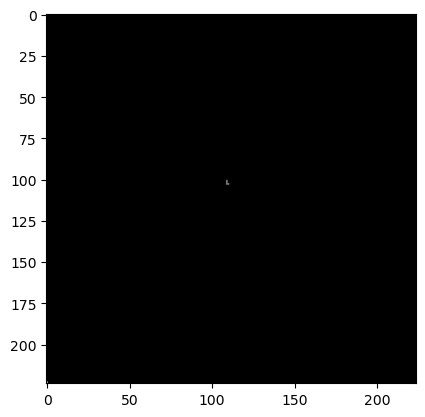

wp 8 level 214.66666666666669
connected_components 2


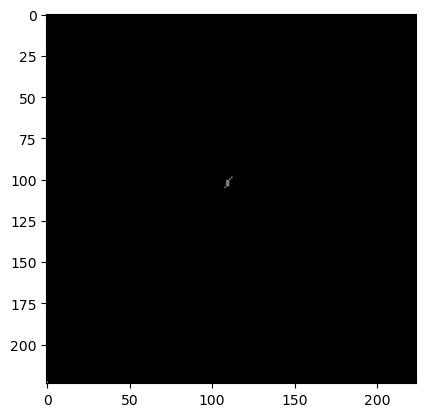

wp 9 level 212.33333333333334
connected_components 4


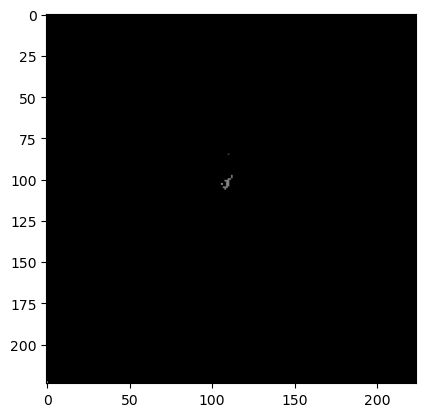

wp 10 level 210.0
connected_components 4


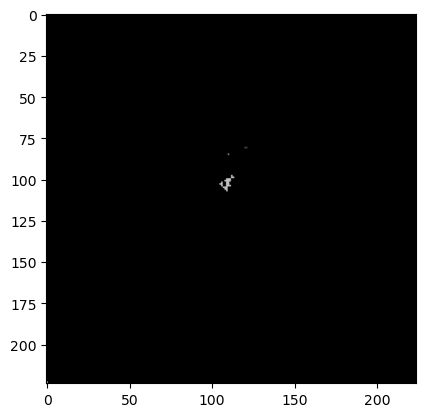

wp 11 level 207.66666666666669
connected_components 4


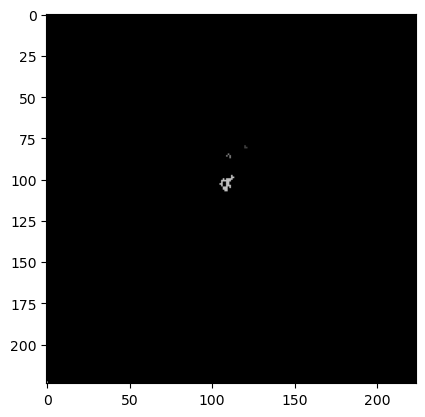

wp 12 level 205.33333333333334
connected_components 6


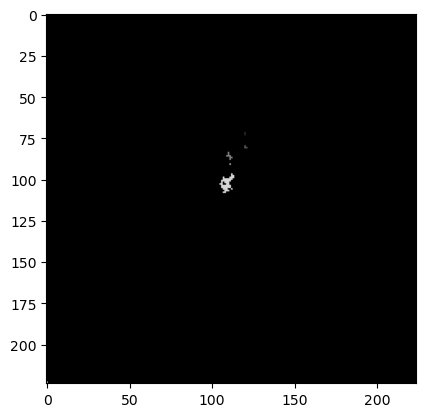

wp 13 level 203.0
connected_components 7


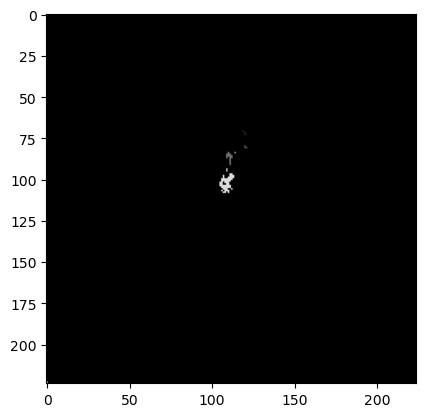

wp 14 level 200.66666666666669
connected_components 7


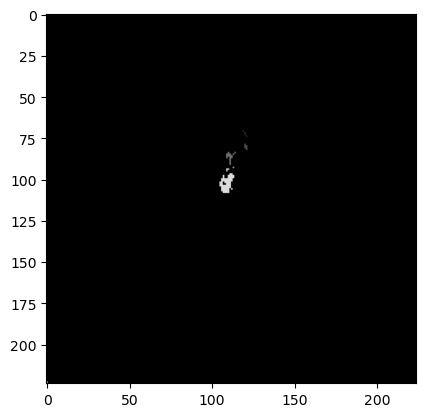

wp 15 level 198.33333333333334
connected_components 8


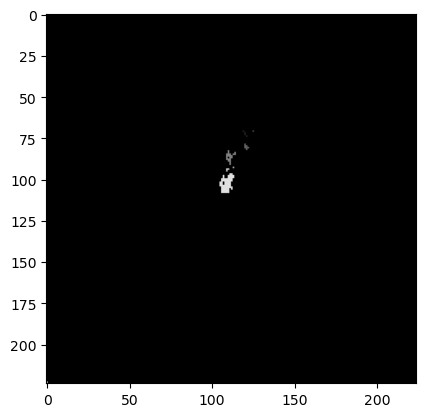

wp 16 level 196.0
connected_components 10


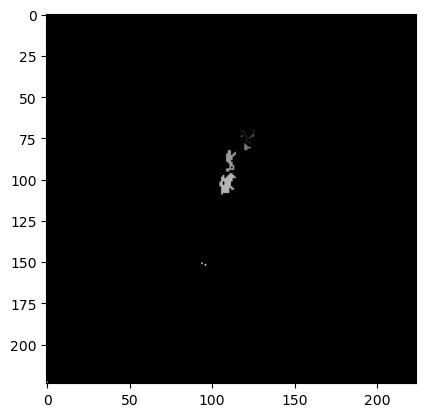

wp 17 level 193.66666666666669
connected_components 11


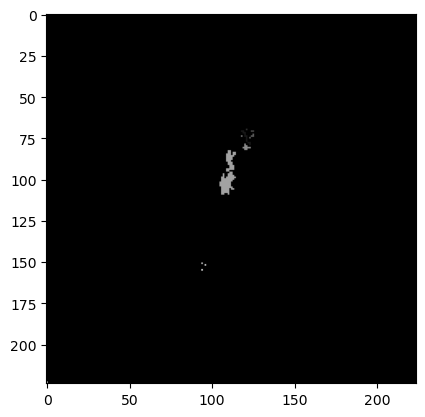

wp 18 level 191.33333333333334
connected_components 10


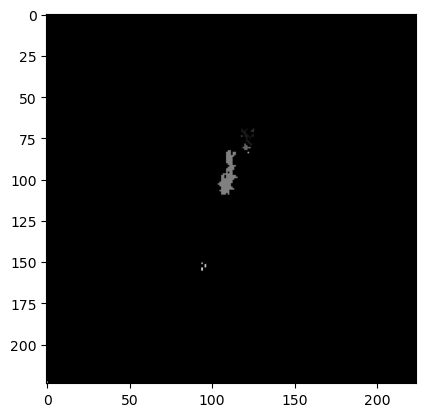

wp 19 level 189.0
connected_components 10


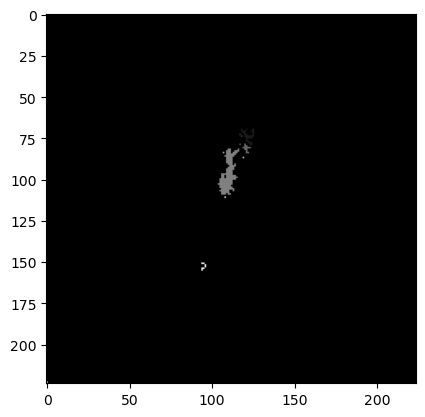

wp 20 level 186.66666666666669
connected_components 8


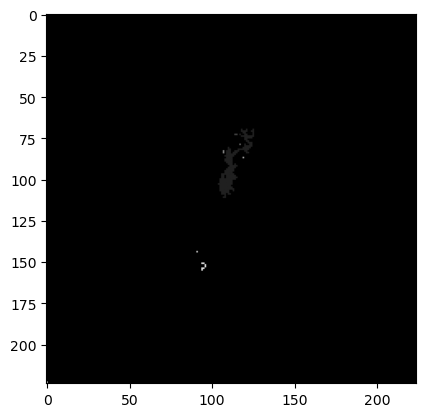

wp 21 level 184.33333333333334
connected_components 9


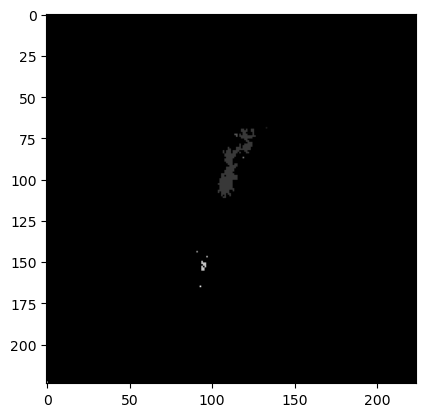

wp 22 level 182.0
connected_components 13


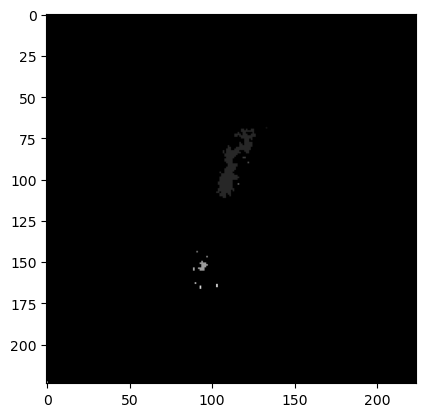

wp 23 level 179.66666666666669
connected_components 17


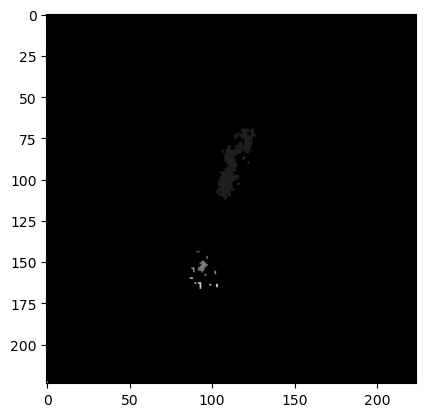

wp 24 level 177.33333333333334
connected_components 20


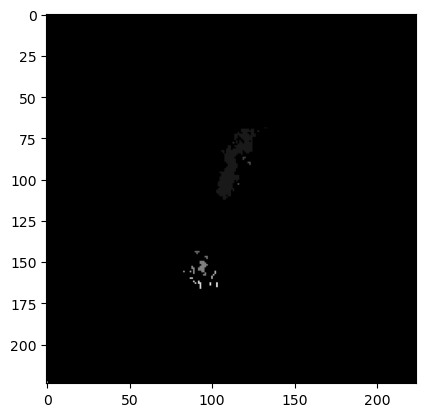

wp 25 level 175.0
connected_components 19


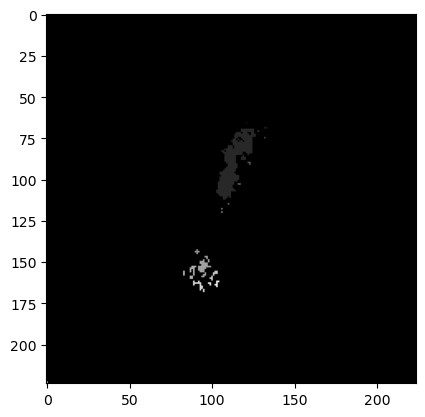

wp 26 level 172.66666666666669
connected_components 25


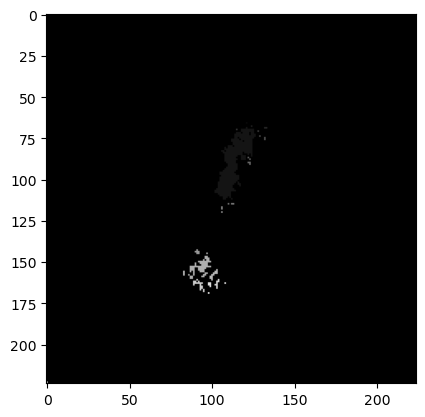

wp 27 level 170.33333333333334
connected_components 27


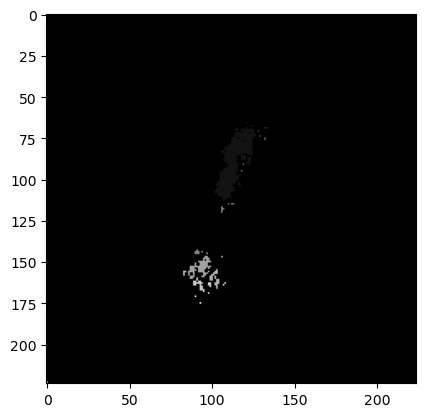

wp 28 level 168.0
connected_components 25


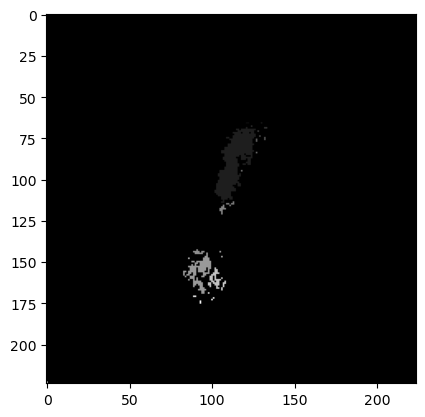

wp 29 level 165.66666666666669
connected_components 26


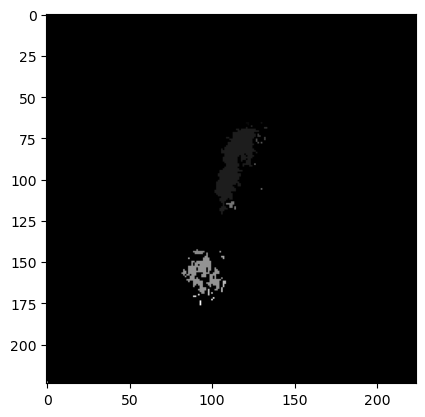

wp 30 level 163.33333333333334
connected_components 22


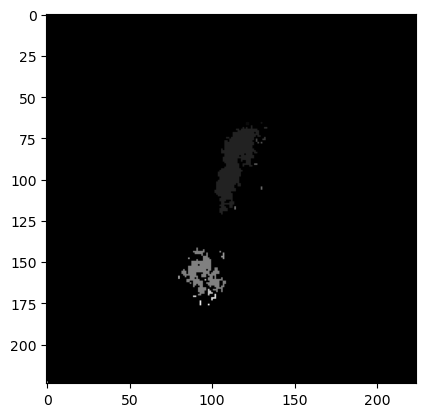

wp 31 level 161.0
connected_components 21


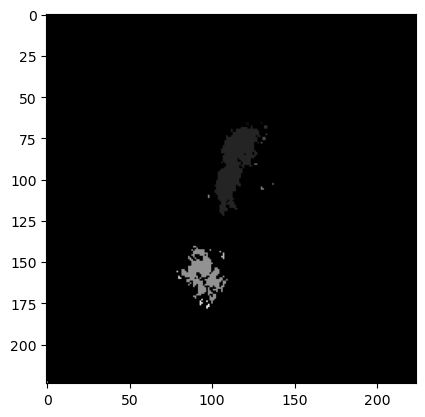

wp 32 level 158.66666666666669
connected_components 28


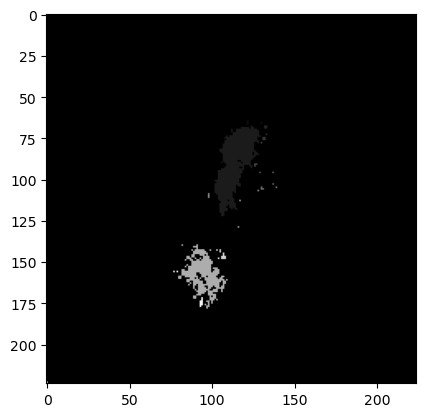

wp 33 level 156.33333333333334
connected_components 29


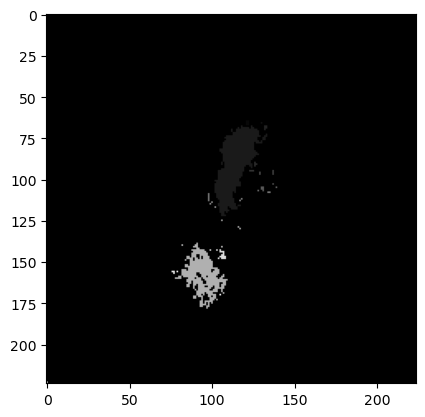

wp 34 level 154.0
connected_components 38


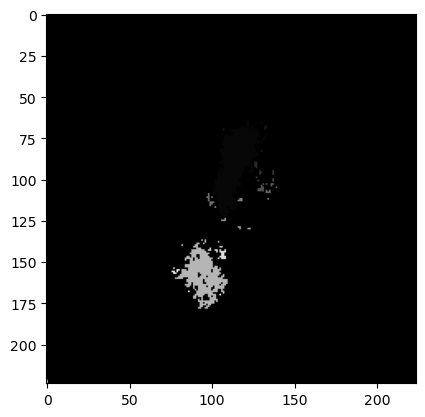

wp 35 level 151.66666666666669
connected_components 27


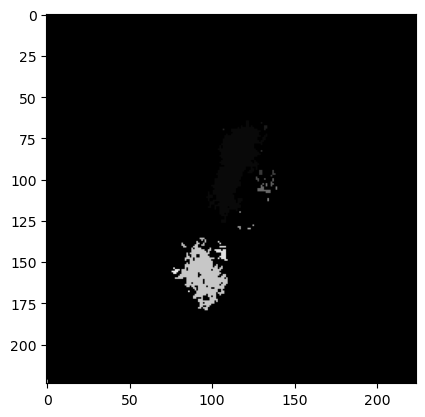

wp 36 level 149.33333333333334
connected_components 25


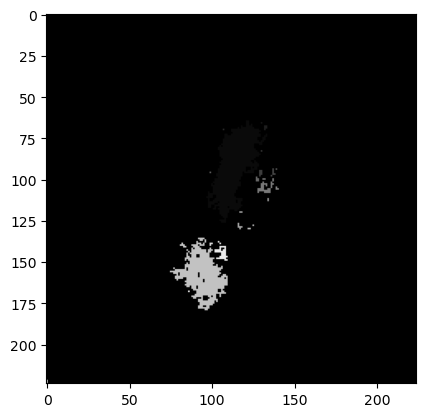

wp 37 level 147.0
connected_components 30


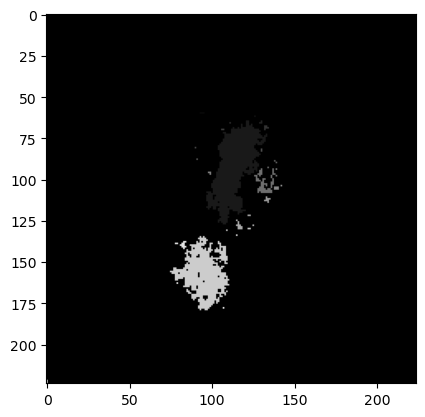

wp 38 level 144.66666666666669
connected_components 36


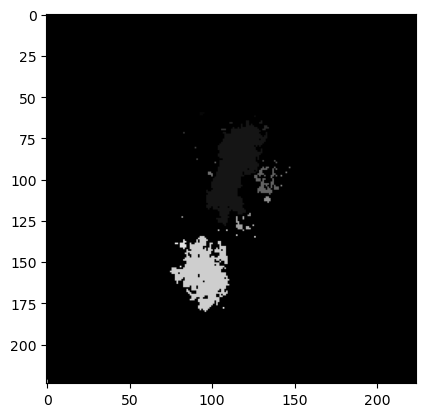

wp 39 level 142.33333333333334
connected_components 41


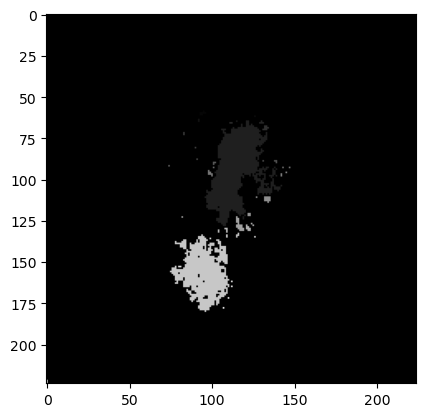

wp 40 level 140.0
connected_components 32


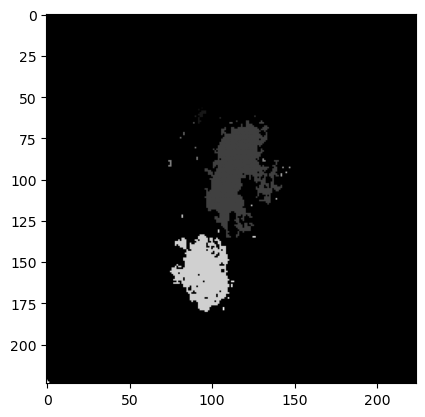

wp 41 level 137.66666666666669
connected_components 39


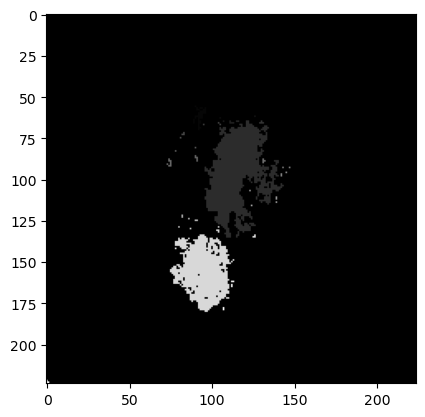

wp 42 level 135.33333333333334
connected_components 39


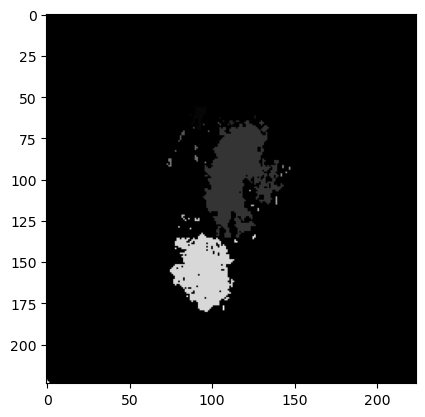

wp 43 level 133.0
connected_components 38


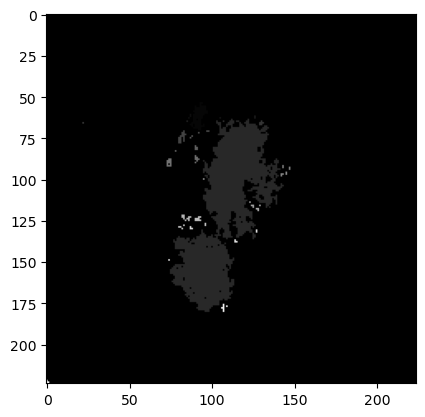

wp 44 level 130.66666666666669
connected_components 34


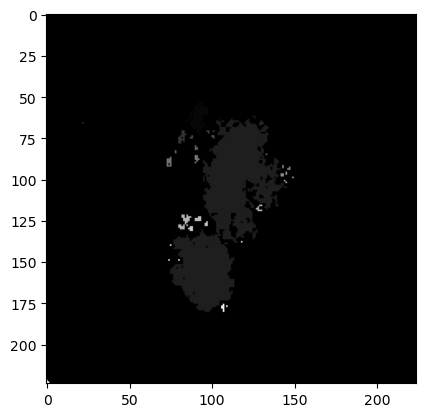

wp 45 level 128.33333333333334
connected_components 36


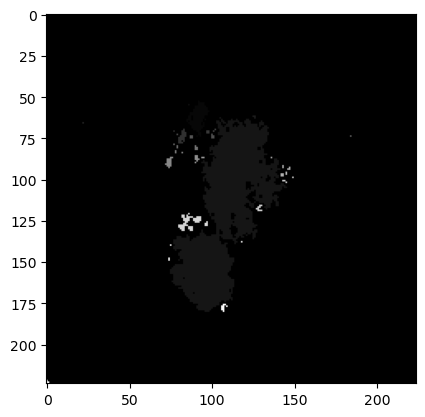

wp 46 level 126.00000000000001
connected_components 31


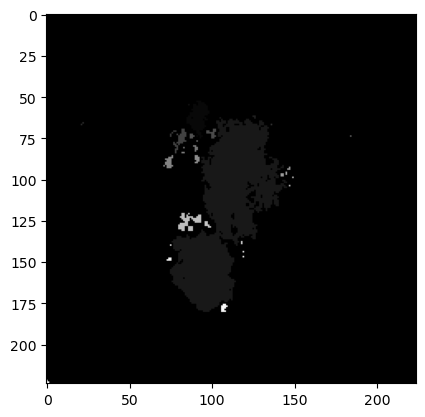

wp 47 level 123.66666666666667
connected_components 32


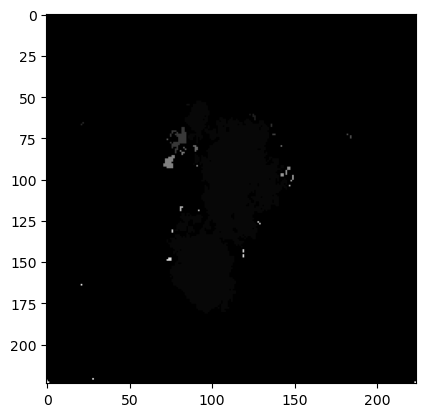

wp 48 level 121.33333333333334
connected_components 27


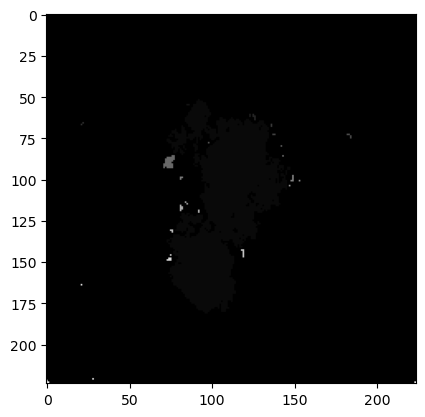

wp 49 level 119.00000000000001
connected_components 24


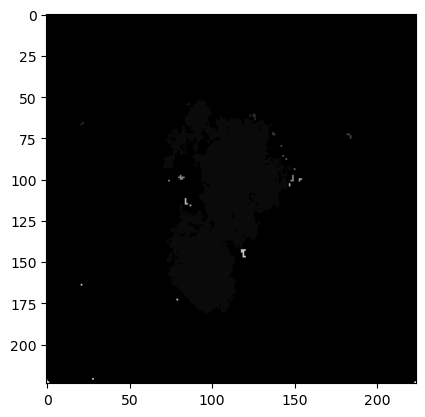

wp 50 level 116.66666666666667
connected_components 32


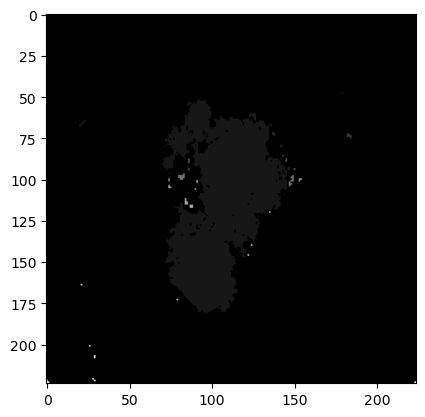

wp 51 level 114.33333333333334
connected_components 36


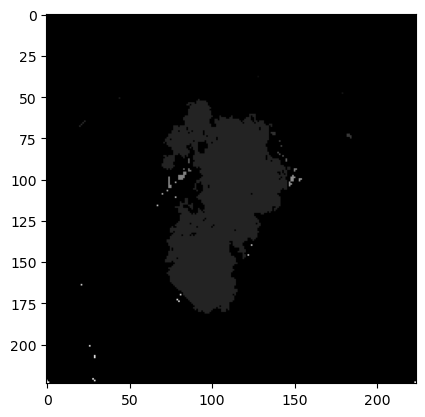

wp 52 level 112.0
connected_components 43


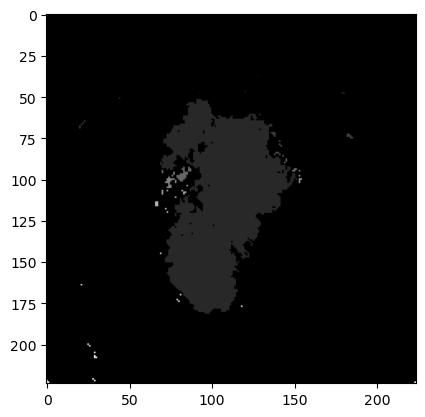

wp 53 level 109.66666666666667
connected_components 37


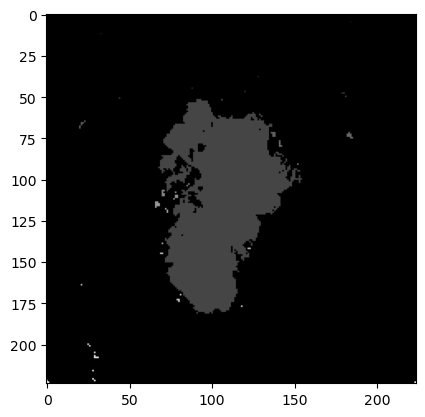

wp 54 level 107.33333333333334
connected_components 39


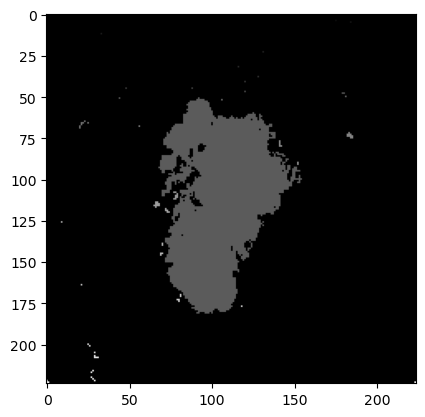

wp 55 level 105.0
connected_components 53


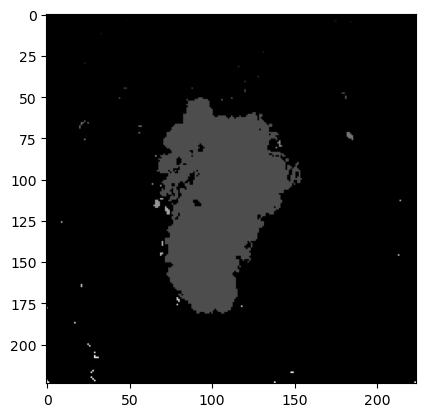

wp 56 level 102.66666666666667
connected_components 64


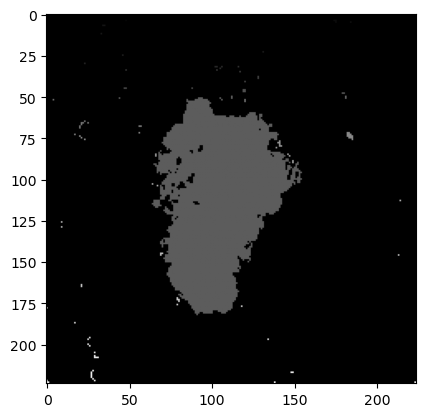

wp 57 level 100.33333333333334
connected_components 74


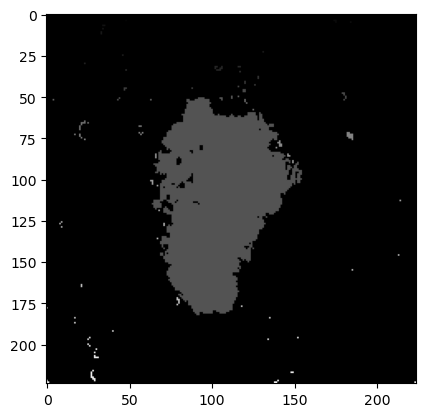

wp 58 level 98.0
connected_components 82


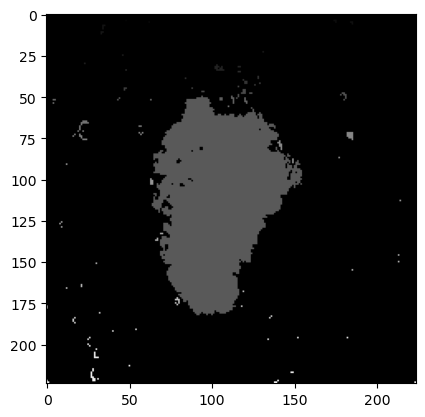

wp 59 level 95.66666666666667
connected_components 93


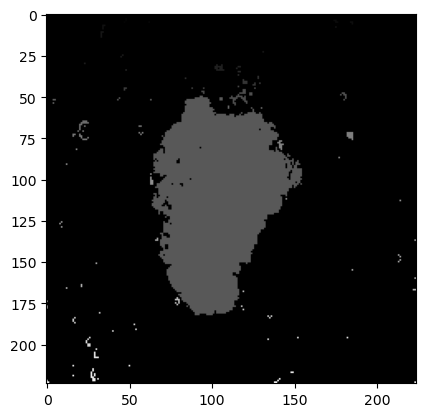

wp 60 level 93.33333333333334
connected_components 97


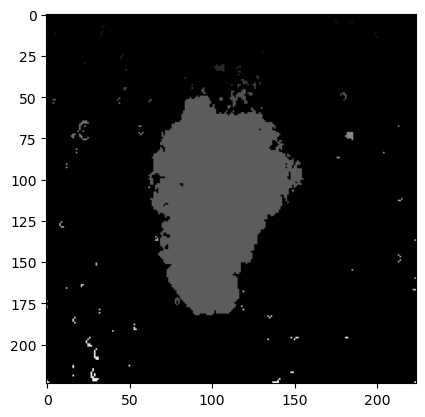

wp 61 level 91.0
connected_components 118


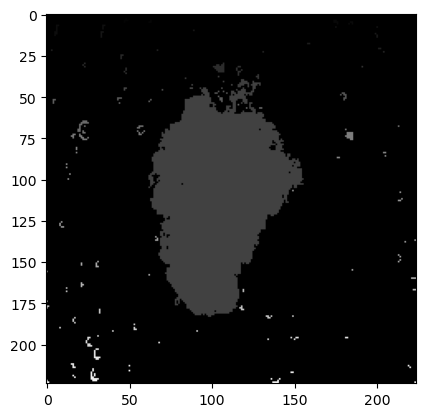

wp 62 level 88.66666666666667
connected_components 124


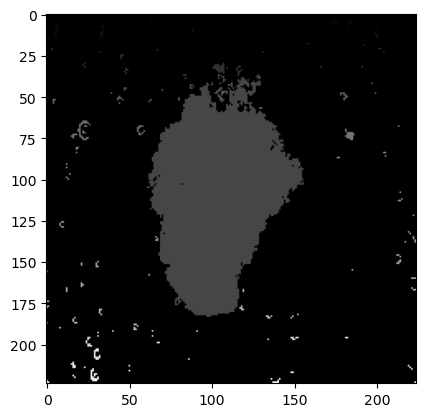

wp 63 level 86.33333333333334
connected_components 145


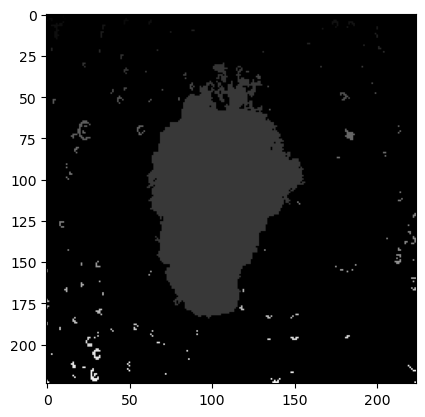

wp 64 level 84.0
connected_components 204


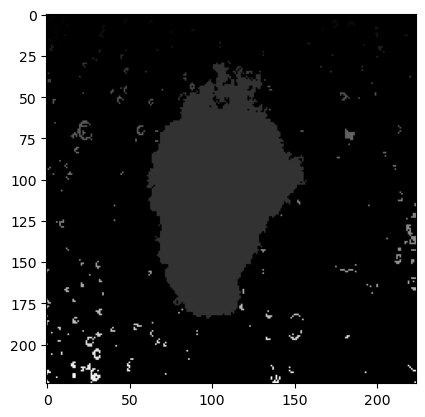

wp 65 level 81.66666666666667
connected_components 246


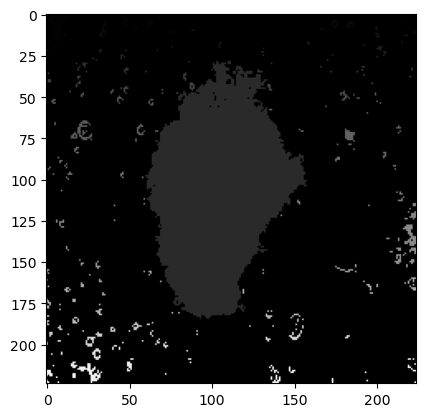

wp 66 level 79.33333333333334
connected_components 278


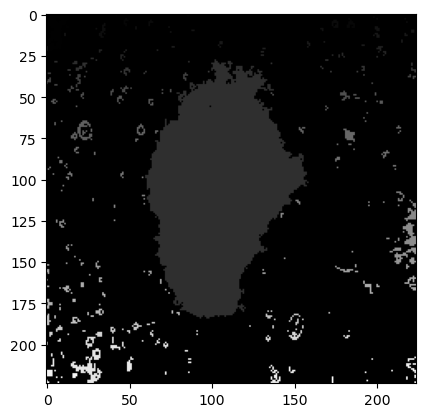

wp 67 level 77.0
connected_components 330


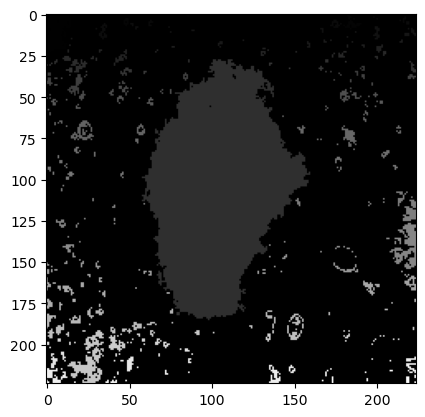

wp 68 level 74.66666666666667
connected_components 356


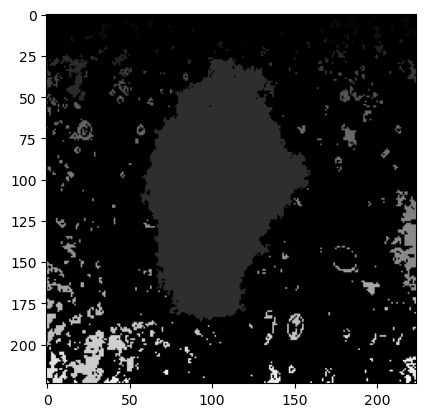

wp 69 level 72.33333333333334
connected_components 372


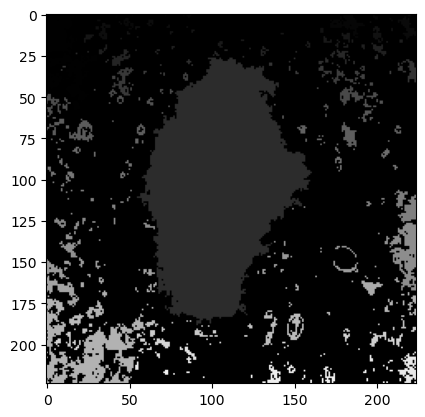

wp 70 level 70.0
connected_components 371


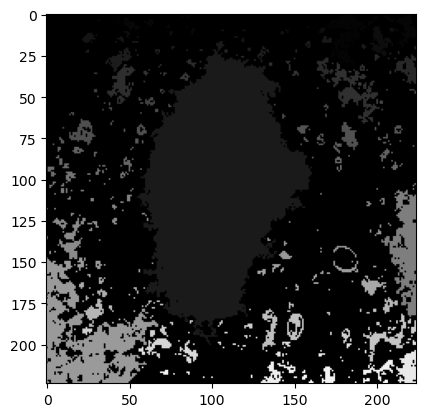

wp 71 level 67.66666666666667
connected_components 365


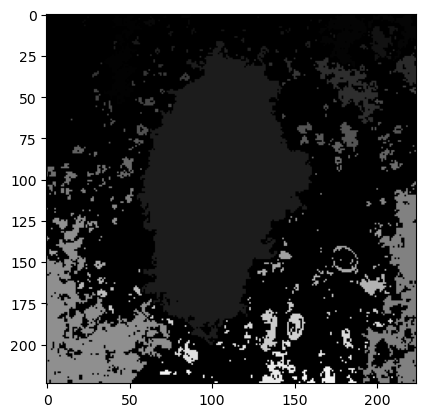

wp 72 level 65.33333333333334
connected_components 319


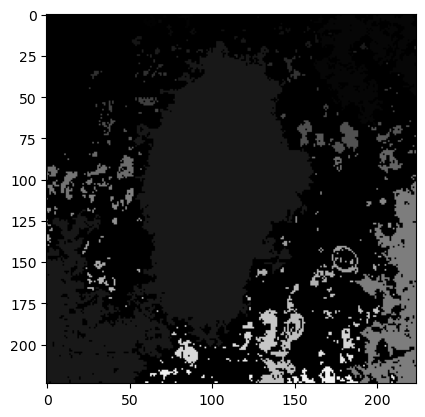

wp 73 level 63.00000000000001
connected_components 266


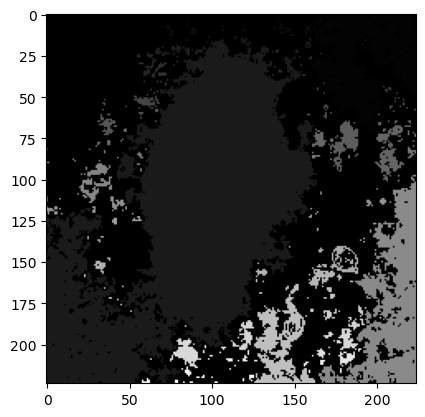

wp 74 level 60.66666666666667
connected_components 154


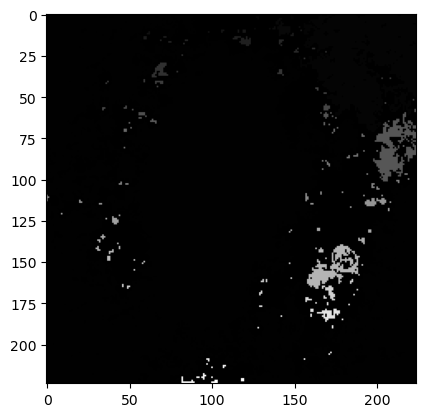

wp 75 level 58.333333333333336
connected_components 137


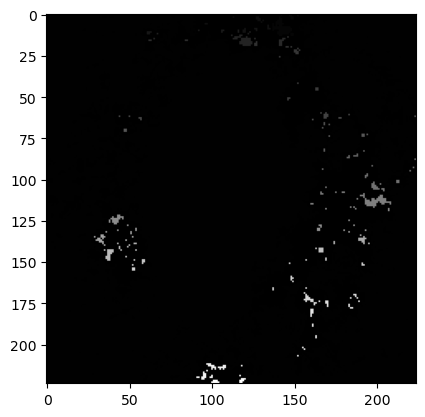

wp 76 level 56.0
connected_components 71


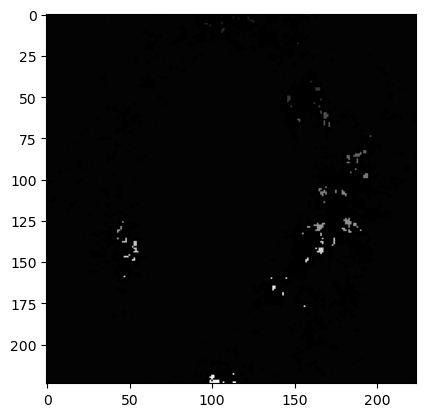

wp 77 level 53.66666666666667
connected_components 44


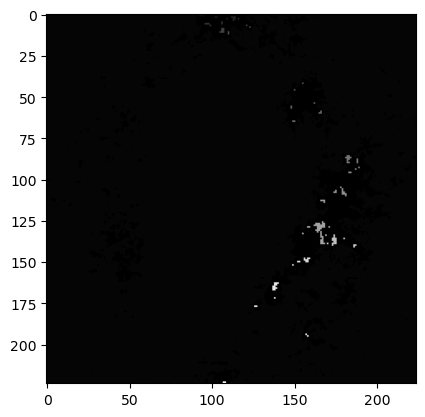

wp 78 level 51.333333333333336
connected_components 22


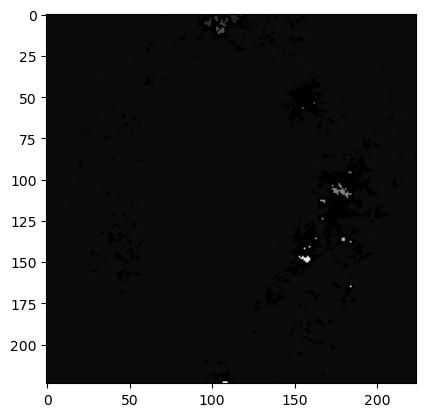

wp 79 level 49.0
connected_components 7


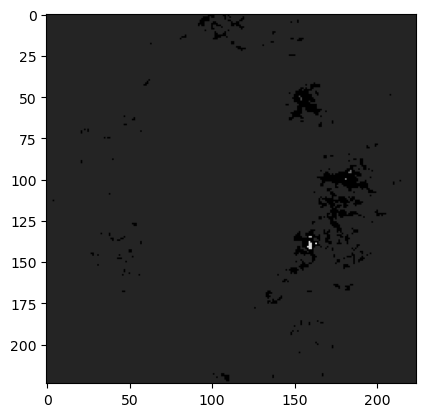

wp 80 level 46.66666666666667
connected_components 5


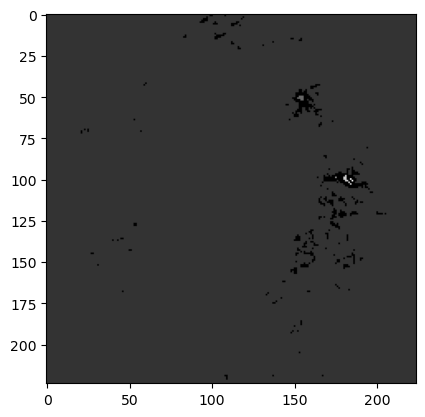

wp 81 level 44.333333333333336
connected_components 2


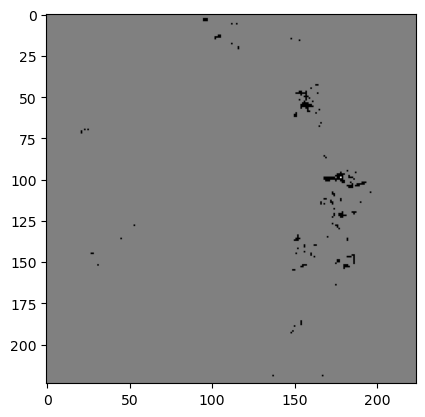

wp 82 level 42.0
connected_components 1


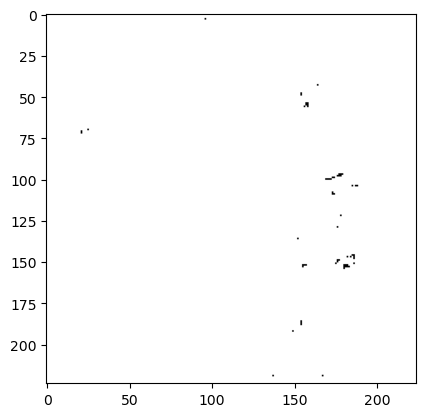

wp 83 level 39.66666666666667
connected_components 1


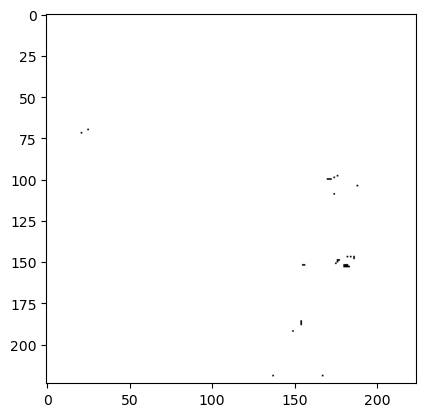

wp 84 level 37.333333333333336
connected_components 1


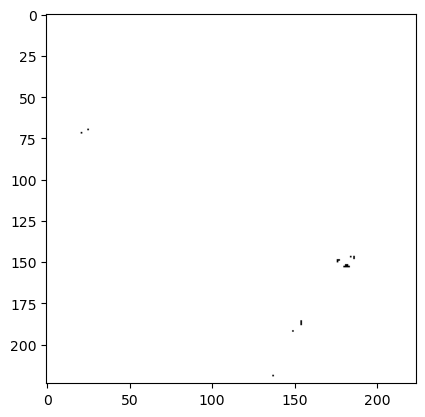

wp 85 level 35.0
connected_components 1


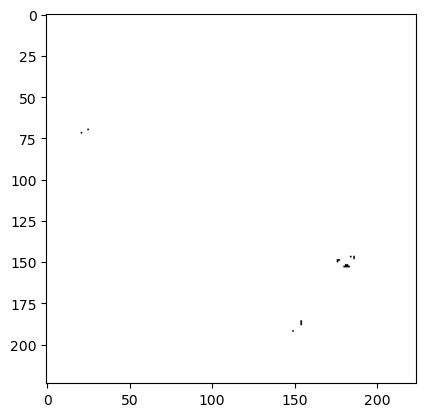

wp 86 level 32.66666666666667
connected_components 1


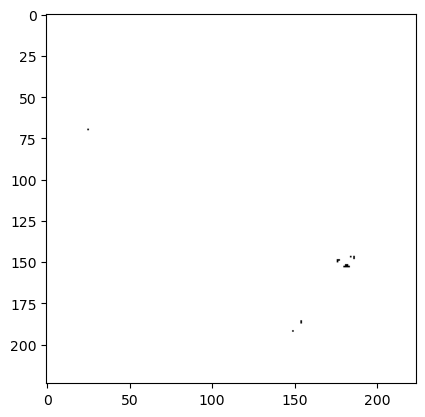

wp 87 level 30.333333333333336
connected_components 1


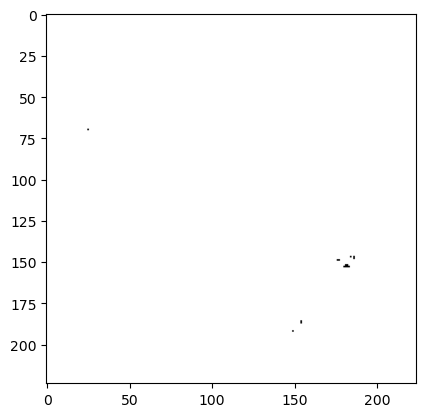

wp 88 level 28.0
connected_components 1


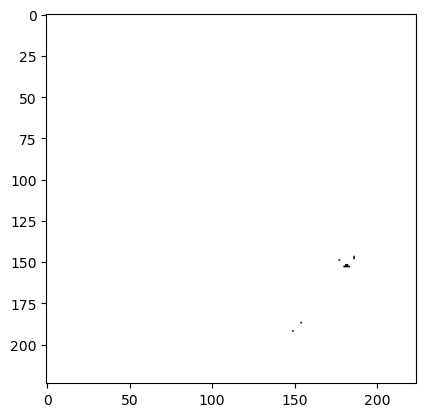

wp 89 level 25.666666666666668
connected_components 1


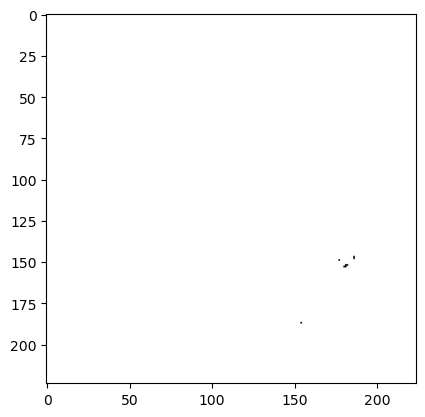

wp 90 level 23.333333333333336
connected_components 1


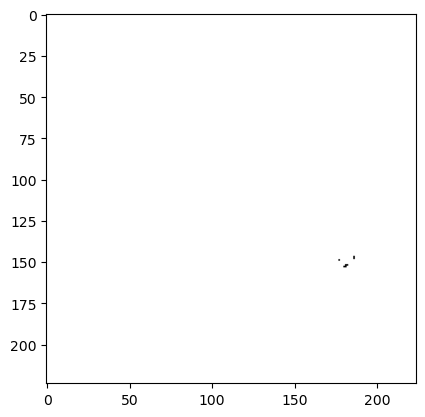

wp 91 level 21.0
connected_components 1


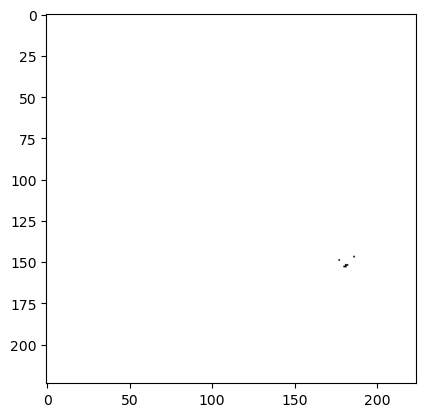

wp 92 level 18.666666666666668
connected_components 1


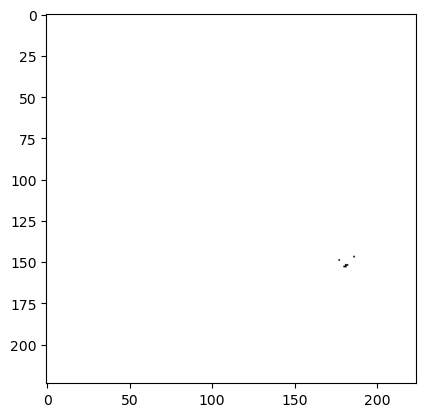

wp 93 level 16.333333333333336
connected_components 1


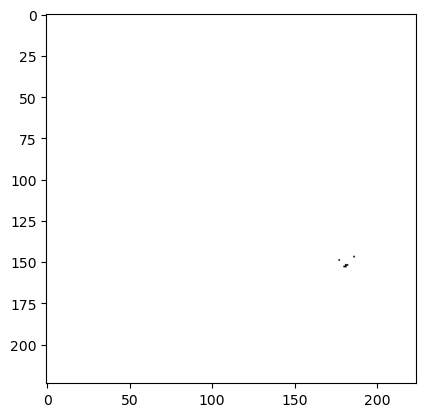

wp 94 level 14.0
connected_components 1


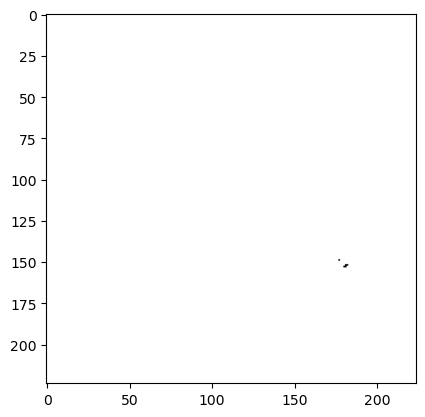

wp 95 level 11.666666666666668
connected_components 1


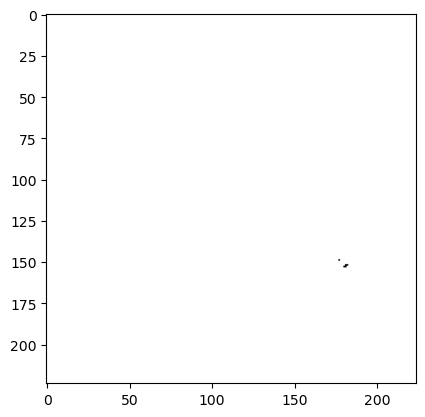

wp 96 level 9.333333333333334
connected_components 1


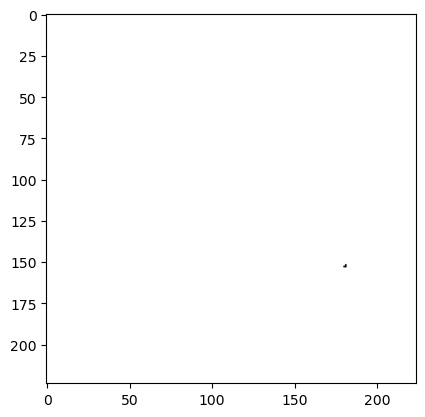

wp 97 level 7.0
connected_components 1


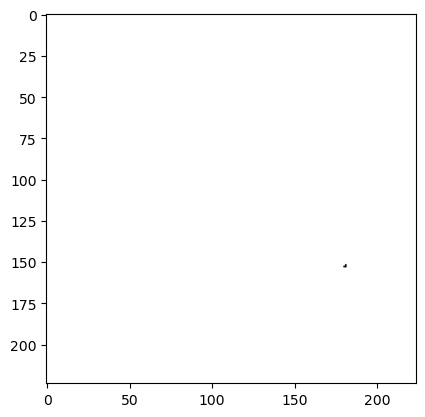

wp 98 level 4.666666666666667
connected_components 1


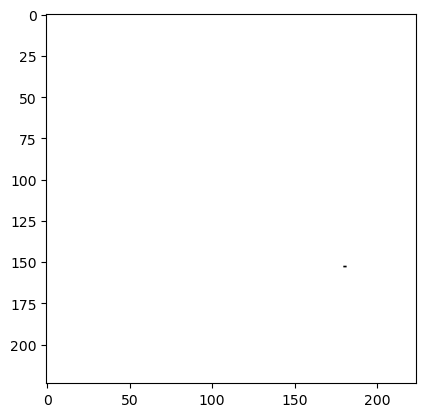

wp 99 level 2.3333333333333335
connected_components 1


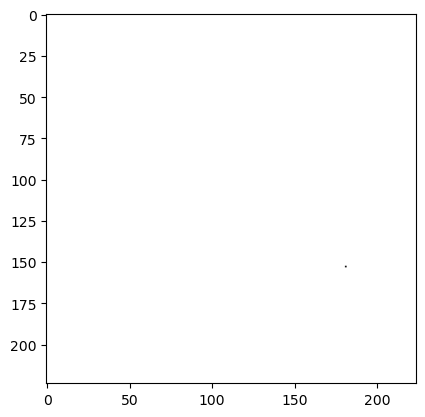

wp 100 level 0.0
connected_components 1


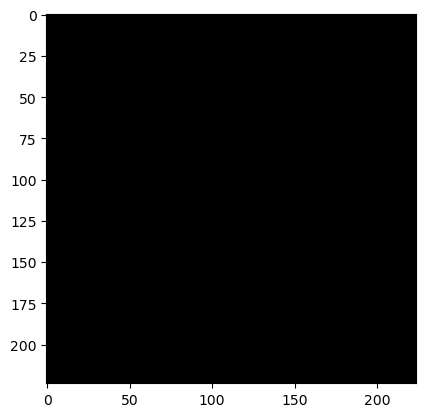

In [22]:
L = np.linspace(np.min(U_train[m]), np.max(U_train[m]), 100)[::-1]
U = U_train[m]
life, barecode, persistence, connected_comp, Per_total, Area_total, euler_total, per, area, euler = function_persistance(U, L, True)

# Geometrically weighted diagram of persistence

In [23]:
P_tilde = np.zeros(len(L))
for i, per_list in zip(per.keys(), per.values()):
    P_tilde = P_tilde + per[i]/np.sum(area[i])

In [24]:
life
diagram_pondere = np.zeros((1, len(life), 3))
i = 0
for idx in life.keys():
    diagram_pondere[0][i][0] = np.linalg.norm(per[idx])*life[idx][0]
    diagram_pondere[0][i][1] = np.linalg.norm(per[idx])*life[idx][1]
    diagram_pondere[0][i][2] = 0
    i=i+1

In [29]:
#persistence_entropy = PersistenceEntropy(normalize=True)

#diagram_pondere = [i for i in diagram_pondere if str(i) != 'nan']
# Calculate topological feature matrix
#X = persistence_entropy.fit_transform(diagram_pondere)

# Visualise feature matrix
#fig_entropy = plot_point_cloud(X)